# November rain

November 2021 was the wettest November on record for Australia.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Image
from scipy.stats import genextreme as gev

from unseen import fileio
from unseen import general_utils
from unseen import indices
from unseen import time_utils

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
bom_file = "/g/data/xv83/dbi599/nov-rain/data/pr_BoM_1900-2021_nov_aus-mean.nc"
model_file = "/g/data/xv83/dbi599/nov-rain/data/pr_CAFE-c5-d60-pX-f6_19950501-20201101_nov_aus-mean.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/nov-rain/data/pr_CAFE-c5-d60-pX-f6_19950501-20201101_nov_aus-mean_bias-corrected-BoM-multiplicative.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/nov-rain/data/ks-test_pr_CAFE-c5-d60-pX-f6_1995-2020_nov_aus-mean_bias-corrected-BoM-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/nov-rain/data/ks-test_pr_CAFE-c5-d60-pX-f6_1995-2020_nov_aus-mean_BoM.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/nov-rain/figures/independence-test_pr_CAFE-c5-d60-pX-f6_19950501-20201101_nov_aus-mean.png"
model_name = "CAFE"
min_lead = 3


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(bom_file), "Must provide an BoM data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

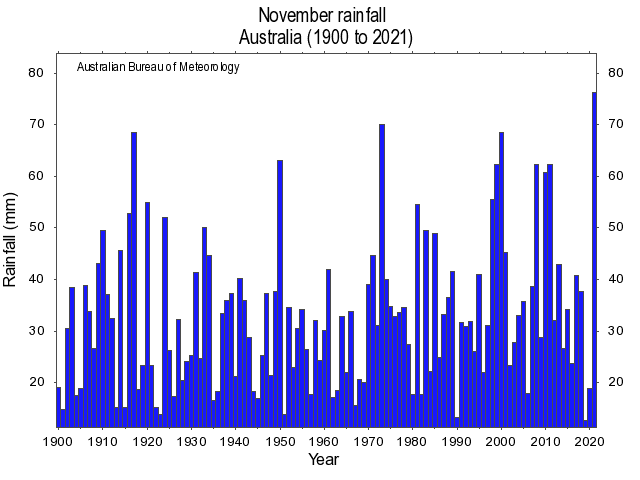

In [5]:
Image(filename='/home/599/dbi599/nov-rain/analysis/pr_BoM_1900-2021_nov_aus-mean.png')

In [6]:
bom_ds = fileio.open_dataset(bom_file)

In [7]:
bom_ds

<xarray.Dataset>
Dimensions:  (time: 122)
Coordinates:
  * time     (time) object 1900-11-15 00:00:00 ... 2021-11-15 00:00:00
Data variables:
    pr       (time) float64 dask.array<chunksize=(122,), meta=np.ndarray>
Attributes:
    history:  Fri Feb 18 11:06:30 2022: /g/data/xv83/dbi599/miniconda3/envs/u...
    source:   http://www.bom.gov.au/climate/change/

In [8]:
years = bom_ds['time'].dt.year.values
bom_df = pd.DataFrame(index=years)
bom_df['pr'] = bom_ds['pr'].values

In [9]:
mean_rainfall = bom_df.mean()
print(mean_rainfall)

pr    32.909262
dtype: float64


In [10]:
pr2021 = bom_ds['pr'].values.max()
print(pr2021)

76.18


In [11]:
ranked_years = bom_df['pr'].sort_values(ascending=False)
ranked_years.head(n=10)

2021    76.18
1973    70.14
1917    68.51
2000    68.41
1950    63.03
2008    62.38
1999    62.30
2011    62.29
2010    60.67
1998    55.49
Name: pr, dtype: float64

In [12]:
bom_gev_shape, bom_gev_loc, bom_gev_scale = indices.fit_gev(bom_df['pr'].values)
print(f'Shape parameter: {bom_gev_shape:.2f}')
print(f'Location parameter: {bom_gev_loc:.2f}')
print(f'Scale parameter: {bom_gev_scale:.2f}')

Shape parameter: -0.07
Location parameter: 26.16
Scale parameter: 10.43


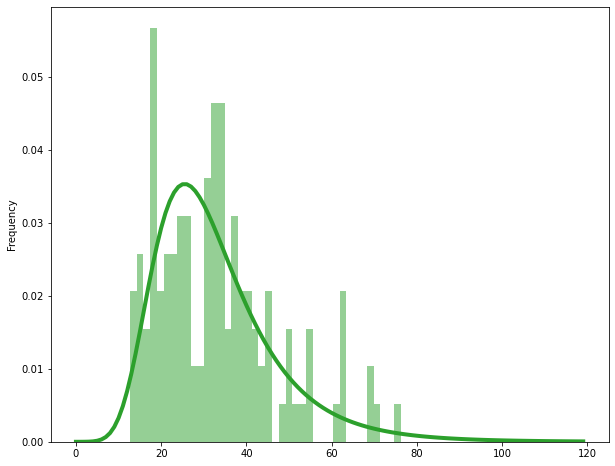

In [13]:
fig, ax = plt.subplots(figsize=[10, 8])
gev_xvals = np.arange(0, 120)
bom_df['pr'].plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
bom_gev_pdf = gev.pdf(gev_xvals, bom_gev_shape, bom_gev_loc, bom_gev_scale)
plt.plot(gev_xvals, bom_gev_pdf, color='tab:green', linewidth=4.0)
plt.show()

In [14]:
for sample_size in [1000, 5000, 10000, 50000, 100000, 500000]:
    bom_gev_data = gev.rvs(bom_gev_shape, loc=bom_gev_loc, scale=bom_gev_scale, size=sample_size)
    bom_percentile, bom_return_period = general_utils.event_in_context(bom_gev_data, pr2021, 'above')
    print(f'Sample size: {sample_size}')
    print(f'{bom_percentile:.2f}% percentile')
    print(f'{bom_return_period:.0f} year return period\n')

Sample size: 1000
98.20% percentile
56 year return period

Sample size: 5000
98.70% percentile
77 year return period

Sample size: 10000
98.50% percentile
67 year return period

Sample size: 50000
98.51% percentile
67 year return period

Sample size: 100000
98.50% percentile
67 year return period

Sample size: 500000
98.44% percentile
64 year return period



Accordining to a GEV fitted to the observations, the event is in the 98th percentile with a 60-70 year return period.

## Model ensemble

In [15]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:    (ensemble: 96, init_date: 52, lead_time: 10)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * init_date  (init_date) object 1995-05-16 00:00:00 ... 2020-11-16 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9
    time       (lead_time, init_date) object dask.array<chunksize=(10, 52), meta=np.ndarray>
Data variables:
    pr         (init_date, lead_time, ensemble) float64 dask.array<chunksize=(1, 10, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_month.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Fri Feb 18 11:13:24 2022: /g/data/xv83/dbi599/miniconda3/envs...
    title:      AccessOcean-AM2

### Independence testing

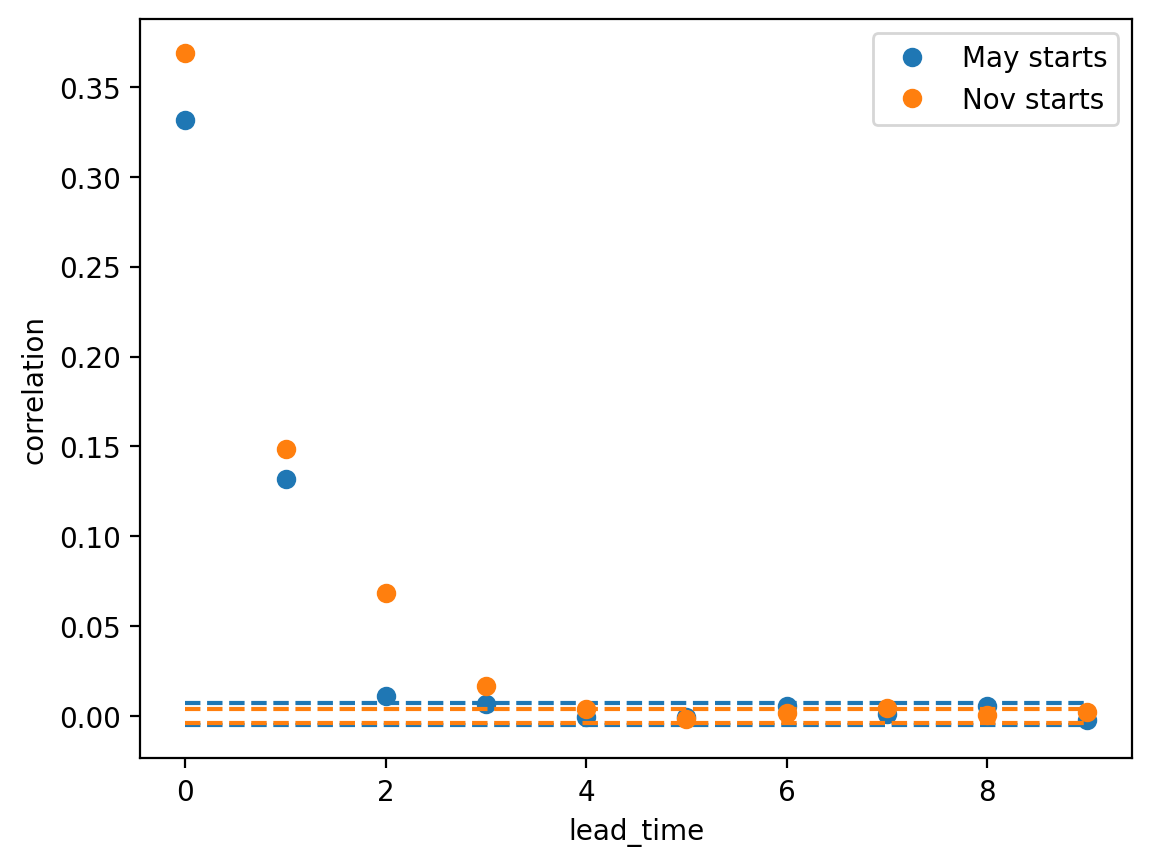

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

3


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

### Bias correction and similarity testing

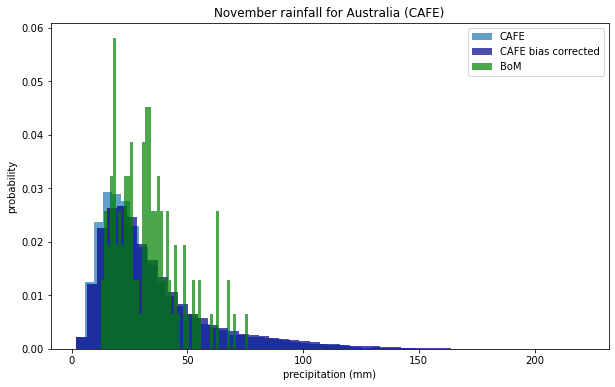

In [20]:
fig = plt.figure(figsize=[10, 6])
model_da.plot.hist(bins=50, density=True, label=model_name, alpha=0.7)
model_bc_ds['pr'].plot.hist(bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7)
bom_ds['pr'].plot.hist(bins=50, density=True, label='BoM', facecolor='green', alpha=0.7)
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'November rainfall for Australia ({model_name})')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/nov-rain/figures/nov_precip_histogram_aus_{model_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [21]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)
similarity_bias_ds['pval'].values

array([0.16408587, 0.14603876, 0.08114537, 0.09772013, 0.09429431,
       0.09575012, 0.10124826])

In [22]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)
similarity_raw_ds['pval'].values

array([0.20995005, 0.27267651, 0.07862586, 0.01200785, 0.0215535 ,
       0.02761747, 0.02224087, 0.02238064, 0.03006841, 0.02088496])

These are the p-values for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

### Exceedance curves

In [23]:
def plot_exceedance(sample_ds, model_name):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'November rainfall for Australia ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('monthly precipitation (mm)')
    ax.axvline(pr2021, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/nov-rain/figures/nov_precip_exceedence_aus_{model_name}.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

In [24]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    start_years = [1960, 1970, 1980, 1990, 2000, 2010]
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + 9
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-31'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        percentile, return_period = general_utils.event_in_context(ds_selection.values, pr2021, 'above')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period\n')

    ax.set_title(f'November rainfall for Australia ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('monthly precipitation (mm)')
    ax.legend()
    ax.axvline(pr2021, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/nov-rain/figures/nov_precip_exceedence_aus_{model_name}_by-decade.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

#### Bias corrected data

In [25]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [26]:
model_bc_da_stacked.shape

(34944,)

/g/data/xv83/dbi599/nov-rain/figures/nov_precip_exceedence_aus_CAFE.png


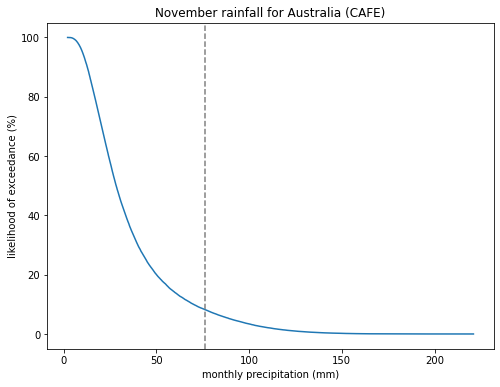

In [27]:
plot_exceedance(model_bc_da_stacked, model_name)

1960-1969


/home/599/dbi599/forks/unseen/unseen/general_utils.py:146: RuntimeWarning: invalid value encountered in long_scalars
  percentile = (np.sum(data < threshold) / n_population) * 100
/home/599/dbi599/forks/unseen/unseen/general_utils.py:147: RuntimeWarning: invalid value encountered in long_scalars
  return_period = n_population / n_events


nan% percentile
nan year return period



1970-1979
nan% percentile
nan year return period



/home/599/dbi599/forks/unseen/unseen/general_utils.py:146: RuntimeWarning: invalid value encountered in long_scalars
  percentile = (np.sum(data < threshold) / n_population) * 100
/home/599/dbi599/forks/unseen/unseen/general_utils.py:147: RuntimeWarning: invalid value encountered in long_scalars
  return_period = n_population / n_events


1980-1989
nan% percentile
nan year return period



/home/599/dbi599/forks/unseen/unseen/general_utils.py:146: RuntimeWarning: invalid value encountered in long_scalars
  percentile = (np.sum(data < threshold) / n_population) * 100
/home/599/dbi599/forks/unseen/unseen/general_utils.py:147: RuntimeWarning: invalid value encountered in long_scalars
  return_period = n_population / n_events


1990-1999


92.36% percentile
13 year return period



2000-2009


92.14% percentile
13 year return period



2010-2019
91.92% percentile
12 year return period



/g/data/xv83/dbi599/nov-rain/figures/nov_precip_exceedence_aus_CAFE_by-decade.png


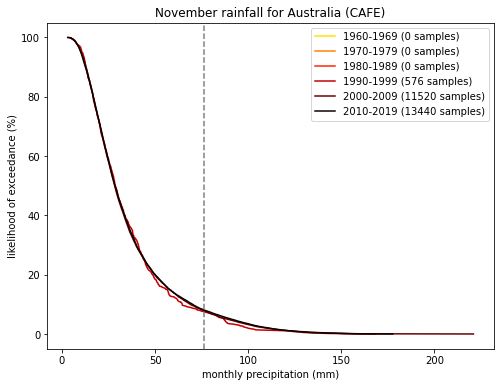

In [28]:
plot_exceedance_by_decade(model_bc_da_stacked, model_name)

In [29]:
percentile_bc, return_period_bc = general_utils.event_in_context(model_bc_da_stacked.values, pr2021, 'above')
print('BIAS CORRECTED DATA')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
91.80% percentile
12 year return period


#### Raw data

In [30]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [31]:
model_da_stacked.shape

(34944,)

/g/data/xv83/dbi599/nov-rain/figures/nov_precip_exceedence_aus_CAFE.png


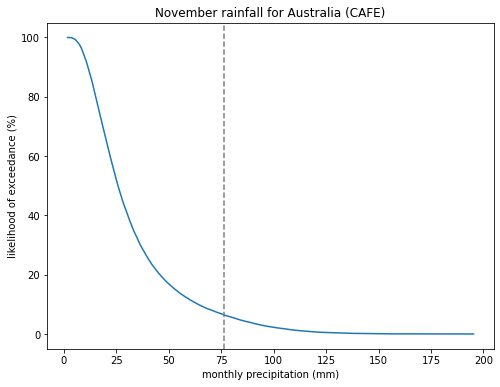

In [32]:
plot_exceedance(model_da_stacked, model_name)

In [33]:
percentile, return_period = general_utils.event_in_context(model_da_stacked.values, pr2021, 'above')
print('RAW DATA')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
93.50% percentile
15 year return period
